In [1]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.0.0
anyio                        3.5.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.11.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       4.1.0
Brotli                       1.0.9
cachetools                   5.3.2
certifi                      2023.11.17
cffi                         1.16.0
chardet                      5.2.0
charset-normalizer           2.0.4
colorama                     0.4.6
comm                         0.1.2
contourpy                    1.2.0
cryptography                 41.0.7
cycler                       0.12.1
debugpy                      1.6.7
decorator                    5.1.1
defusedxml                   0.7.

In [2]:
import tensorflow as tf 
import os

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
len(gpus)

1

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Rescaling, Dropout, BatchNormalization
from tensorflow.keras.layers import Resizing
from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16

In [7]:
import os
import cv2
import imghdr

data_directory = "Dataset/PetImages"
valid_extensions = ["jpg", "jpeg", "png", "bmp"]

for image_class in os.listdir(data_directory):
    print(f"Processing {image_class}...")
    for image in os.listdir(os.path.join(data_directory, image_class)):
        
        img_path = os.path.join(data_directory, image_class, image)
        
        try:
            img = cv2.imread(img_path)
            extension = imghdr.what(img_path)
            img_size = os.path.getsize(img_path)

            if img_size < 10000:
                print(f"File too small. Removing {image} from {image_class}")
                os.remove(img_path)

            if extension not in valid_extensions:
                print(f"Invalid image type. Removing image {image} from {image_class}")
                os.remove(img_path)

        except:
            print(f"Error reading file {image}. Removing from {image_class}.")
            os.remove(img_path)
    
            

print("--------------------------------------------------------------------------------")
for image_class in os.listdir(data_directory):
    print(f"Remaining image in {image_class} are {len(os.listdir(os.path.join(data_directory, image_class)))}")


Processing Cat...
Processing Dog...
--------------------------------------------------------------------------------
Remaining image in Cat are 11698
Remaining image in Dog are 11783


In [8]:
import glob
import os

img_paths = glob.glob(os.path.join(data_directory,'*/*.*')) # assuming you point to the directory containing the label folders.

for image_path in img_paths:
    try:
        img_bytes = tf.io.read_file(image_path)
        decoded_img = tf.io.decode_image(img_bytes)
    except tf.errors.InvalidArgumentError as e:
        print(f"Found bad path {image_path}...{e}. Removing...")
        os.remove(image_path)

In [9]:
data_directory = "Dataset/PetImages"


data = tf.keras.utils.image_dataset_from_directory(data_directory, batch_size = 16)


Found 23481 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

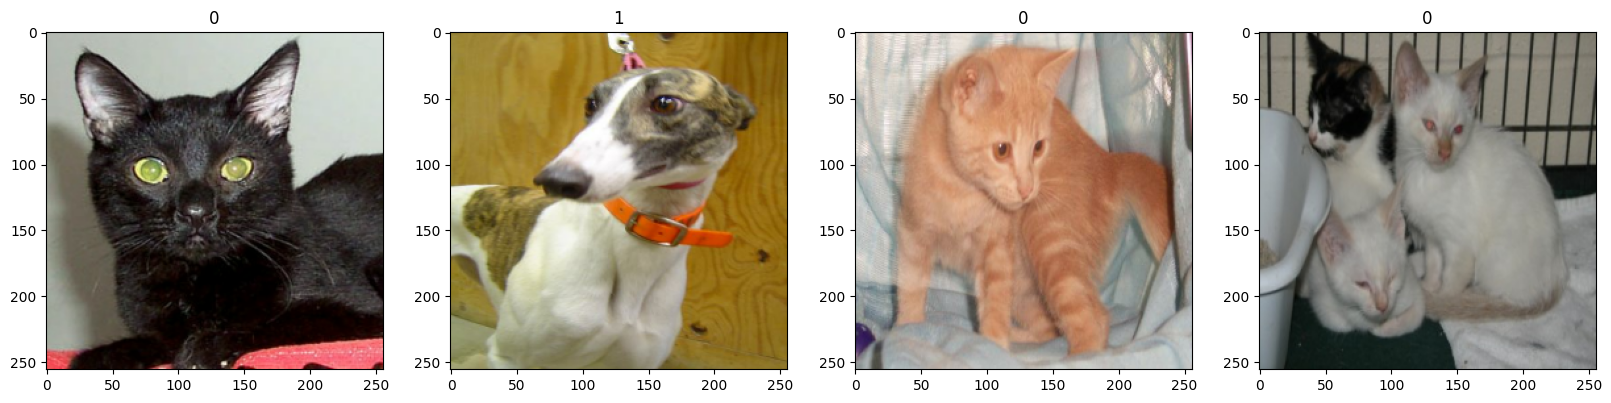

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [13]:
#tensorflow will assign 0, 1, 2, 3.... based on the order in which the folders are present in the main directory

decoder = os.listdir(data_directory)

#You can use the indices to access the actual label here

In [14]:
len(data)

#an output of 'a' represets total 'a' batches and a * batch_size images in total

1468

In [15]:
train_size = int(len(data)*.7)+1
validation_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

print(f"Training size: {train_size}")
print(f"Validation size: {validation_size}")
print(f"Testing size: {test_size}")

print(f"Missed: {len(data) - (train_size + validation_size + test_size)}")
#Distribute the "Missed" batches in testing or training respectively by +1, +2 etc

Training size: 1028
Validation size: 293
Testing size: 147
Missed: 0


In [16]:
train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test = data.skip(train_size+validation_size).take(test_size)

In [17]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(256, 256, 3)
)

In [18]:
conv_base.trainable = False

In [19]:
model = Sequential()

model.add(Rescaling(1./225.))
model.add(conv_base)
model.add(Flatten())
model.add(Dense(1024*2, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(2, activation = 'sigmoid'))

In [20]:
model.build((16, 256, 256, 3))

In [21]:
model.compile(loss=SparseCategoricalCrossentropy(), optimizer="SGD", metrics=["accuracy"])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (16, 256, 256, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (16, 32768)               0         
                                                                 
 dense (Dense)               (16, 2048)                67110912  
                                                                 
 dense_1 (Dense)             (16, 1024)                2098176   
                                                                 
 dense_2 (Dense)             (16, 512)                 524800    
                                                                 
 dense_3 (Dense)             (16, 256)                 1

In [23]:
from keras.callbacks import ModelCheckpoint

filepath = "checkpoints/improvement - {val_accuracy:.2f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only= True, mode = 'max')
callbacks_list = [checkpoint]

In [24]:
training = model.fit(train, epochs=20, validation_data=validation, callbacks=callbacks_list)

Epoch 1/20
1028/1028 [==============================] - 279s 263ms/step - loss: 0.3965 - accuracy: 0.8141 - val_loss: 0.2110 - val_accuracy: 0.9185
Epoch 2/20
1028/1028 [==============================] - 272s 264ms/step - loss: 0.2309 - accuracy: 0.9021 - val_loss: 0.1791 - val_accuracy: 0.9313
Epoch 3/20
1028/1028 [==============================] - 272s 264ms/step - loss: 0.1921 - accuracy: 0.9202 - val_loss: 0.1630 - val_accuracy: 0.9337
Epoch 4/20
1028/1028 [==============================] - 271s 264ms/step - loss: 0.1709 - accuracy: 0.9297 - val_loss: 0.2250 - val_accuracy: 0.8865
Epoch 5/20
1028/1028 [==============================] - 272s 264ms/step - loss: 0.1487 - accuracy: 0.9385 - val_loss: 0.1404 - val_accuracy: 0.9443
Epoch 6/20
1028/1028 [==============================] - 271s 263ms/step - loss: 0.1407 - accuracy: 0.9428 - val_loss: 0.2778 - val_accuracy: 0.8869
Epoch 7/20
1028/1028 [==============================] - 271s 264ms/step - loss: 0.1276 - accuracy: 0.9492 - val_

In [25]:
model.load_weights("checkpoints\improvement - 0.95.keras")

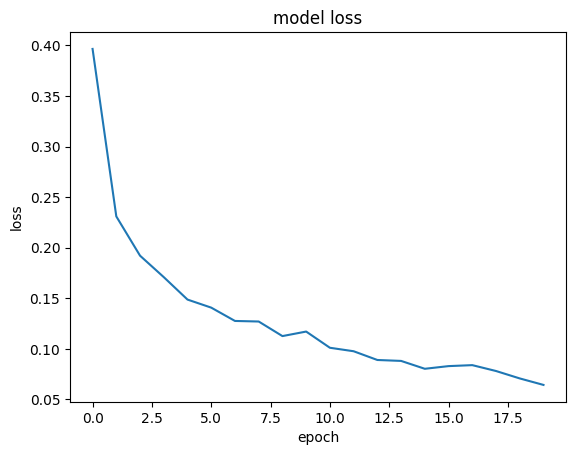

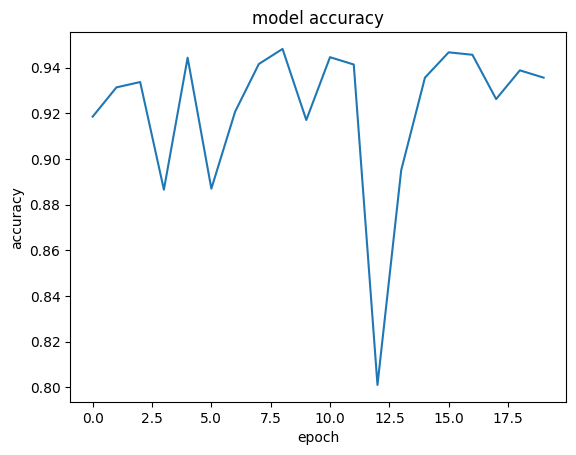

In [31]:
plt.plot(training.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

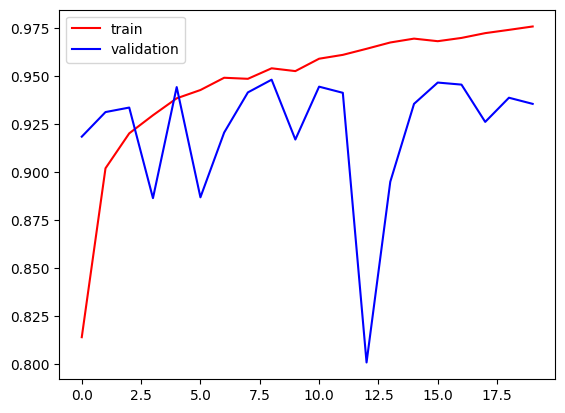

In [32]:
plt.plot(training.history['accuracy'],color='red',label='train')
plt.plot(training.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [26]:
model.save("ImageClassifier_95.h5")

In [27]:
model.save("ImageClassifier_full_model")

INFO:tensorflow:Assets written to: ImageClassifier_full_model\assets


INFO:tensorflow:Assets written to: ImageClassifier_full_model\assets


In [3]:
import pickle

model = tf.keras.models.load_model("ImageClassifier_95.h5")

pickle.dump(model, open('image_classifier_pickle.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://0968c051-38f5-4a6f-baa0-6ac1b68185d3/assets


INFO:tensorflow:Assets written to: ram://0968c051-38f5-4a6f-baa0-6ac1b68185d3/assets
